In [1]:
%matplotlib inline
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

from datetime import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import os
from PIL import Image
from tqdm.notebook import tqdm
cuda = torch.device('cuda:0')

In [2]:
import pickle
import pandas as pd
import os
from skimage.io import imread
from  torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms

In [3]:
image_dim = 224

def show_sample(sample):
    """
    Displays a sample as they come out of the trainloader.
    """
    
    mask = sample['mask']
    
    masked_im = sample['full_image'].clone()
    masked_im[mask] = 0.0

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(sample['caption'], size=20)
    ax1.imshow(sample['full_image'].permute(1,2,0).numpy().clip(0,1))
    ax2.imshow(masked_im.permute(1,2,0).numpy().clip(0,1))
    ax3.imshow(sample['full_image'][mask].view(3,100,100).permute(1,2,0).numpy().clip(0,1))
    plt.show()

class COCODataset(Dataset):
    def __init__(self, annotations, datadir, transform=None):
        """
        Dataset of obfuscated coco images, with captions.
        
        annotations: load from pickle, akshay's processed annotations
        datadir: Preprocessed data. Contains /originals and /masked
        tranforms: function to be run on each sample
        """
        
        self.datadir = datadir
        self.transform = transform
        self.annotations = annotations
        self.filenames = os.listdir(datadir)
        
        # Since every 5 samples is the same image, we have a one image cache.
        # TODO this may get fucky with shuffle? we can find out later.
        self.last_image = None
        self.last_index = None
        
    def __len__(self):
        return len(self.filenames) * 5
    
    def __getitem__(self, idx):
        """
        Gets images from the dataset.
        
        Each image has 5 replicas, with different captions and sections
        
        Returns: dictionary with blanked out ['image'] and ['caption']
            image: FloatTensor
            caption: string (may later be a list)
        """

        # Load image or retrieve from cache
        
        image_filename = self.filenames[idx // 5]
        image_id = int(image_filename.split(".")[0])
        
        
        if self.last_index is not None and idx // 5 == self.last_index // 5:
            full_image = self.last_image
        else:
            image_filepath = os.path.join(self.datadir, image_filename)
            full_image = Image.open(image_filepath)
            self.last_image = full_image
        
        self.last_index = idx
        full_image = full_image.convert("RGB") # The occasional 1 channel grayscale image is in there.
        full_image = full_image.resize((image_dim, image_dim))

        # Fetch annotation, mask out area
        anno = self.annotations[image_id][idx % 5]
       
        x1 = anno['coord_start'][0]
        y1 = anno['coord_start'][1]
        x2 = x1 + 100
        y2 = y1 + 100
        
        mask = torch.zeros(3, image_dim,image_dim,dtype=torch.bool)
        mask[:,y1:y2,x1:x2] = True

        sample = {
            'caption': anno['caption'],
            'full_image': full_image, # Automatically stacked by the loader
            'image_id':image_id,
            'mask':mask # Automatically stacked by the loader
         }

        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [4]:
%%time
annos = pd.read_pickle("../annotations_train2017.pickle")

# Recommended resnet transforms.
normalize = transforms.Normalize(mean=[.5,.5,.5],
                                 std=[.5,.5,.5])
# TODO change masking logic to accomodate this
#resnet_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), normalize, transforms.ToTensor()])
#resnet_transform = transforms.Compose([transforms.Resize((image_dim,image_dim)), transforms.ToTensor(), normalize])
resnet_transform = transforms.Compose([transforms.ToTensor()])

def basic_transform_sample(sample):
    """
    A "default" transformer. Applies recommended resnet transforms.
    """
    #sample['masked_image'] = resnet_transform(sample['masked_image'])
    sample['full_image'] = resnet_transform(sample['full_image'])
    return sample

dataset_train = COCODataset(annos, "../data/train2017", transform=basic_transform_sample)
trainloader = DataLoader(dataset_train, batch_size=64, shuffle=False, num_workers=2) # VERY important to make sure num_workers > 0.

CPU times: user 1.42 s, sys: 209 ms, total: 1.63 s
Wall time: 1.63 s


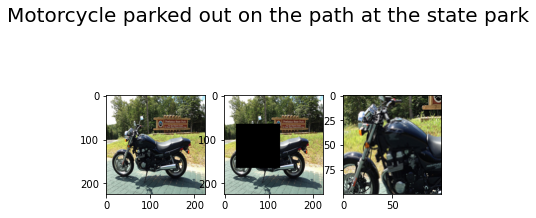

In [5]:
show_sample(dataset_train[0])

In [6]:
class rotfoNET_AE(nn.Module):
    def __init__(self):
        super(rotfoNET_AE, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)
        self.unconv1 = nn.ConvTranspose2d(6,3,kernel_size=(5,5))
        self.maxunpool1 = nn.MaxUnpool2d(kernel_size=(2,2))
        self.unmaxunpool2 = nn.MaxUnpool2d(kernel_size=(2,2))
        
        self.encoder1 = nn.Sequential(
            nn.Tanh(),
            nn.Conv2d(6, 12,kernel_size=(5,5)),
        )
        
        self.encoder2 = nn.Sequential(
            nn.Tanh(),
            nn.Conv2d(12, 16, kernel_size=(5,5)),
            nn.Tanh()
        )
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(16, 12, kernel_size=(5,5)),
            nn.Tanh()
        )
        
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(12,6,kernel_size=(5,5)),
            nn.Tanh(),
        )
        

    def forward(self, x):
        x = self.conv1(x)
        x,indices1 = self.maxpool1(x)
        x = self.encoder1(x)
        x,indices2 = self.maxpool2(x)
        x = self.encoder2(x)
        
        x = self.decoder2(x)
        x = self.unmaxunpool2(x, indices2)
        x = self.decoder1(x)
        x = self.maxunpool1(x,indices1)
        x = self.unconv1(x)
        x = nn.Tanh()(x)
        return x


In [8]:
batch_size = 64
lr = 1e-3

trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, num_workers=3) # VERY important to make sure num_workers > 0.

model = rotfoNET_AE().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

img_size = 64 # size of each image dimension


In [ ]:
# ----------
#  Training
# ----------
n_epochs = 20
for epoch in tqdm(range(0, n_epochs)):
    for i, batch in enumerate(trainloader):
        
        full_imgs = batch['full_image'].cuda()
        mask = batch['mask']
        masked_imgs = full_imgs.detach().clone()
        
        masked_imgs[mask] = 0.0
        
        optimizer.zero_grad()
        gen_imgs = model(masked_imgs)
        
        gen_rois = gen_imgs[mask]
        full_rois = full_imgs[mask]
        loss = .8*criterion(full_rois, gen_rois) + .2*criterion(full_imgs, gen_imgs)
        
        loss.backward()
        optimizer.step()

        if i%1000 ==0 :
            print(f"[Epoch {epoch}/{n_epoch}] [Batch {i}] [loss: {loss.item()}]")
            save_image(full_imgs[1,:,:,:], f'./samples/AE_mse_AaBb_original_{epoch}_{i}.png')
            save_image(gen_imgs[1,:,:,:], f'./samples/AE_mse_AaBb_recon_{epoch}_{i}.png')
            torch.save(model.state_dict(), f'ckpt_rotfoNET_AE_mse_AaBb_{epoch}_{i}.pth')

[Epoch 0/1] [Batch 0] [loss: 0.2502235472202301]
[Epoch 0/1] [Batch 1000] [loss: 0.03802641108632088]
[Epoch 0/1] [Batch 2000] [loss: 0.049120549112558365]
[Epoch 0/1] [Batch 3000] [loss: 0.03751808777451515]
[Epoch 0/1] [Batch 4000] [loss: 0.03386089950799942]
[Epoch 0/1] [Batch 5000] [loss: 0.031575702130794525]
[Epoch 0/1] [Batch 6000] [loss: 0.03572576493024826]
[Epoch 0/1] [Batch 7000] [loss: 0.04204201698303223]
[Epoch 0/1] [Batch 8000] [loss: 0.03936423361301422]
[Epoch 0/1] [Batch 9000] [loss: 0.03826289623975754]
[Epoch 1/1] [Batch 0] [loss: 0.04344233125448227]
[Epoch 1/1] [Batch 1000] [loss: 0.03173740208148956]
[Epoch 1/1] [Batch 2000] [loss: 0.041780985891819]
[Epoch 1/1] [Batch 3000] [loss: 0.03283834084868431]
[Epoch 1/1] [Batch 4000] [loss: 0.032046593725681305]
[Epoch 1/1] [Batch 5000] [loss: 0.031239261850714684]
[Epoch 1/1] [Batch 6000] [loss: 0.034638263285160065]
[Epoch 1/1] [Batch 7000] [loss: 0.04115679860115051]
[Epoch 1/1] [Batch 8000] [loss: 0.0388511419296264